# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [1]:
!pip -q install tf_slim
!pip -q install pycocotools
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 358kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 2.8MB/s 


In [2]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 2156, done.
remote: Counting objects: 100% (2156/2156), done.
remote: Compressing objects: 100% (1854/1854), done.
remote: Total 2156 (delta 506), reused 971 (delta 278), pack-reused 0
Receiving objects: 100% (2156/2156), 30.38 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (506/506), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd models/research
pip -q install .

In [5]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/med_res_2.zip" .
  !unzip -q med_res_2.zip -d Data
  # Remove the zip file 
  !rm med_res_2.zip

In [6]:
# if 'extra_furnitures' not in os.listdir():
#   !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_furnitures.zip" .
#   !unzip -q extra_furnitures.zip -d extra_furnitures
#   !rm extra_furnitures.zip

# if 'extra_mattresses' not in os.listdir():
#   !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_mattresses.zip" .
#   !unzip -q extra_mattresses.zip -d extra_mattresses
#   !rm extra_mattresses.zip

# if 'extra_various' not in os.listdir():
#   !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_various.zip" .
#   !unzip -q extra_various.zip -d extra_various
#   !rm extra_various.zip

# if 'extra_WEEE' not in os.listdir():
#   !cp "/content/drive/My Drive/ML/waste_detection/Data/extra_WEEE.zip" .
#   !unzip -q extra_WEEE.zip -d extra_WEEE
#   !rm extra_WEEE.zip

In [7]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import math
import numpy as np
import tensorflow_addons as tfa
from six import BytesIO
from tqdm import tqdm 
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [8]:
# Helper functions 
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  if not seed:
    random.seed(1)
    random.shuffle(files)
    training_set = files[0:train_length]
    testing_set = files[-test_length:]
  else:
    training_set = []
    testing_set = []
    for filename in files:
      if filename in seed:
        testing_set.append(filename)
      elif filename not in seed:
        training_set.append(filename)

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [9]:
# Split data into train and test folders

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/images')
label_path = os.path.join(current_dir, 'Data/bboxes')

label_names = {1: 'black_bag_waste'}

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

# Note: fire_extinguishers will be combined with gas_bottles_or_cylinders

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

222
157


In [10]:
try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

test_images = []
with open('Data/test_set.txt') as seed:
  for line in seed:
    test_images.append(line.split('\n')[0])

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.9, seed=test_images, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

Created train and test directories
train folder: 139, test folder: 18


In [11]:
# pathlist = ['extra_furnitures/', 
#             'extra_mattresses/',
#             'extra_various/',
#             'extra_WEEE/']

# count = 0
# for extra_path in pathlist:
#   extra_image_path = extra_path + 'images/'
#   extra_bbox_path = extra_path + 'bboxes/'
#   for filepath in os.listdir(extra_image_path):
#     filename = filepath.split('/')[-1]
#     # print(filename)
#     if filename.endswith('.jpg'):
#       annotation_file = filename[:-4] + '_bboxs.json'
#       if annotation_file in os.listdir(extra_bbox_path):
#         with open(extra_bbox_path+annotation_file, 'r') as file:
#           annotation = json.load(file)
#           filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
#           for Class in filtered_annotation:
#             # Only append if not empty
#             if Class is not None:
#               count += 1
#               os.replace(extra_image_path+filename, 'Data/images/train/' + filename)
#               os.replace(extra_bbox_path+annotation_file, 'Data/bboxes/' + annotation_file)
#               break
#         # print(annotation_file)

# print('Added {} images'.format(count))
# print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

In [12]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

difficult_label_dir = 'Data/bboxes_d/'

def json_to_np_d(dir):
  
  output_difficults = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(difficult_label_dir, file[:-4]+'_bboxs_d.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      filtered_annotation = np.array([extract(label, label_names[i]) for i in label_names])

      difficults = np.array([])

      for index, category in enumerate(filtered_annotation):
        if category is not None:
          for box in category:
            difficults = np.append(difficults, box[1])

      output_difficults.append(difficults.astype('int32'))

  return output_difficults

y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)
y_test_difficults = json_to_np_d(test_dir)

In [13]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels):
  for label in labels:
    for box in label:
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes)
y_test_boxes = normalize_boxes(y_test_boxes)

print(y_test_boxes[1])

[[0.07371795 0.0631068  0.21794872 0.2342233 ]
 [0.15224359 0.40898058 0.34935897 0.56917476]
 [0.37980769 0.72208738 0.54166667 0.89563107]]


In [14]:
# Merge Classes + distribution Summary

distribution_train = {}
distribution_test = {}
distribution_test_trivial = {}

for i in label_names:
  distribution_train[label_names[i]] = 0
  distribution_test[label_names[i]] = 0
  distribution_test_trivial[label_names[i]] = 0

for annotation in y_train_classes:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_train[label_names[annotation[j]]] += 1

for annotation in y_test_classes:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_test[label_names[annotation[j]]] += 1

print('Train Set')
print(distribution_train)
print('\nTest set')
print(distribution_test)

Train Set
{'black_bag_waste': 480}

Test set
{'black_bag_waste': 132}


In [15]:
# Filtering to trivial boxes only:

temp_difficults_test = []
for i, sample in enumerate(y_test_difficults):
  temp_index = []
  for j, diff in enumerate(sample):
    if diff == 1:
      temp_index.append(j)
  temp_difficults_test.append(temp_index)

# temp_difficults[1]

y_test_boxes_trivial = []
y_test_classes_trivial = []

for i, temp_difficult in enumerate(temp_difficults_test):
  y_test_boxes_trivial.append(np.delete(y_test_boxes[i], temp_difficult, 0))
  y_test_classes_trivial.append(np.delete(y_test_classes[i], temp_difficult, 0))

for annotation in y_test_classes_trivial:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_test_trivial[label_names[annotation[j]]] += 1

print('Test Set')
print(distribution_test)
print('\nTest set (Trivial annotations only)')
print(distribution_test_trivial)

Test Set
{'black_bag_waste': 132}

Test set (Trivial annotations only)
{'black_bag_waste': 98}


In [16]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')


  0%|          | 0/18 [00:00<?, ?it/s]


 Appended and resized 139 training images


100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


 Appended and resized 18 training images


## np_to_tensors()




In [17]:
# Prepping data, converting np arrays into tensors 

num_classes = 1

def np_to_tensors(image_nps, box_nps, class_nps):
  label_id_offset = 1

  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


In [18]:
# Optional: visulize images

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 6
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[i+ offset],
      y_test_classes[i+ offset],
      np.ones(shape=[y_test_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [18]:
# if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
#   !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
#   !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/


!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!rm ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-09-03 18:37:40--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  95.3MB/s    in 2.4s    

2020-09-03 18:37:43 (95.3 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [19]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt'

# # raw_checkpoint = checkpoint_path

# pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
# checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'


# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [ ]:
# [i.name for i in detection_model.trainable_variables]
# # len(detection_model.trainable_variables)

In [20]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [22]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

### get_variables()


In [23]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

### train()

In [24]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_prob = 0.2,
          rotate_prob = 0.2,
          hue_prob = 0.2):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  # tf.keras.backend.clear_session()

  num_batches = (len(x_train_np) // batch_size) + 1

  print('Started fine-tuning!', flush=True)
  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    cv_loss = test_evaluate()

    for i in tqdm(range(num_batches)):

      image_list, boxes_list, classes_list = [], [], []

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]

      for key in example_keys:
        temp_image = x_train_np[key]
        temp_box = y_train_boxes[key]
        
        # Augmentation:
        temp_image, temp_box = random_horizontal_flip(temp_image, temp_box, flip_prob)
        temp_image, temp_box = random_rotate(temp_image, temp_box, rotate_prob)
        temp_image, temp_box = random_hue(temp_image, temp_box, hue_prob)

        image_list.append(temp_image)
        boxes_list.append(temp_box)
        classes_list.append(y_train_classes[key])

      image_tensors, boxes_tensors, classes_tensors = np_to_tensors(image_list, boxes_list, classes_list)

      # Training step (forward pass + backwards pass)
      total_loss = train_step_fn(image_tensors, boxes_tensors, classes_tensors)

      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches
    
    print(f'epoch {e+1} of {epochs}, loss= {epoch_loss}, cv_loss = {cv_loss}')
  
  cv_loss = test_evaluate()

  print(f'final cv_loss: {cv_loss}')
  print('Done fine-tuning!')

### test_evaluate()

In [25]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size + 1
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    loss += train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)
  
  return loss.numpy()/num_batches

### random_hue()

In [34]:
def random_hue(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(image_np, 0.2), 0.1), 0.8, 1.2).numpy()
  return image_np, boxes

### random_horizontal_flip()

In [27]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.copy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tempboxes

def random_horizontal_flip(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.flip_left_right(image_np).numpy()
    boxes = flip_box_left_right(boxes)
  return image_np, boxes

### random_rotate()

In [28]:
def two_points_to_four_points(box):
  coord_1 = (box[0], box[1])
  coord_2 = (box[2], box[1])
  coord_3 = (box[2], box[3])
  coord_4 = (box[0], box[3])
  return([coord_1, coord_2, coord_3, coord_4])

def rotate_coordinates(boxes, alpha):
  output_boxes = []
  for j, box in enumerate(boxes):
    box = two_points_to_four_points(box)
    for i, coord in enumerate(box):
      x_rel = coord[0] - 0.5
      y_rel = 0.5 - coord[1]
      if -1e-6 < x_rel < 1e-6:
        x_rel = 1e-6
      r = ((x_rel)**2 + (y_rel)**2)**0.5
      theta = math.atan(y_rel/x_rel)
      if theta < 0:
        if y_rel > 0:
          theta += math.pi
      if theta > 0:
        if y_rel < 0:
          theta += math.pi

      new_coord = (r * math.cos(theta+alpha) + 0.5, 0.5 - r*math.sin(theta+alpha))
      box[i] = new_coord
    output_boxes.append(box)

  return output_boxes

def rotate_box(boxes, alpha):
  boxes = rotate_coordinates(boxes, alpha)
  output_boxes = np.array([0, 0, 0, 0])
  for box in boxes:
    xmin = min(coord[0] for coord in box)
    ymin = min(coord[1] for coord in box)
    xmax = max(coord[0] for coord in box)
    ymax = max(coord[1] for coord in box)

    if xmin < 0: 
      xmin = 0
    if xmax > 1:
      xmax = 1
    if ymin < 0:
      ymin = 0
    if ymax > 1:
      ymax = 1

    output_boxes = np.vstack([output_boxes, [xmin, ymin, xmax, ymax]])
  
  return output_boxes[1:]

def random_rotate(image_np, boxes, probability):

  if random.random() < probability:
    alpha = random.random() * math.pi/4 - math.pi/8
    image_np = tfa.image.rotate(image_np, alpha).numpy()
    boxes = rotate_box(boxes, -alpha)

  return image_np, boxes


In [29]:
# plt.rcParams['figure.figsize'] = [30, 20]

# idx = 0

# plt.subplot(1, 4, 1)
# plot_detections(
#       cv2.resize(x_train_np[idx], dsize=(421, 320), interpolation=cv2.INTER_CUBIC).astype('int'),
#       y_train_boxes[idx],
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# # alpha = -math.pi/4

# rotated_image, rotated_box = random_rotate(x_train_np[idx], y_train_boxes[idx], 1)

# plt.subplot(1, 4, 2)
# plot_detections(
#       rotated_image,
#       rotated_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# flipped_image, flipped_box = random_horizontal_flip(x_train_np[idx], y_train_boxes[idx], 1)

# plt.subplot(1, 4, 3)

# plot_detections(
#       flipped_image,
#       flipped_box,
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# hue_image = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(x_train_np[idx], 0.2), 0.1), 0.8, 1.2)

# plt.subplot(1, 4, 4)
# plot_detections(
#       hue_image.numpy(),
#       y_train_boxes[idx],
#       y_train_classes[idx],
#       np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
#       category_index)

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [30]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 

In [ ]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!


## Top


### Hyperparameters


In [31]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 20
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss = test_evaluate()
print(test_loss)

# Untuned - 1.45610507329305

1.438976526260376


### Train

In [35]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2)

Started fine-tuning!


100%|██████████| 28/28 [00:23<00:00,  1.19it/s]


epoch 1 of 20, loss= 0.9589511241231646, cv_loss = 1.438976526260376


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 2 of 20, loss= 0.7573778629302979, cv_loss = 0.7112182378768921


100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


epoch 3 of 20, loss= 0.7437749803066254, cv_loss = 0.6600461006164551


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 4 of 20, loss= 0.704823225736618, cv_loss = 0.6845127940177917


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 5 of 20, loss= 0.7057984960930688, cv_loss = 0.6632025837898254


100%|██████████| 28/28 [00:21<00:00,  1.27it/s]


epoch 6 of 20, loss= 0.6930131986737251, cv_loss = 0.6440359354019165


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 7 of 20, loss= 0.6900939047336578, cv_loss = 0.6603354811668396


100%|██████████| 28/28 [00:21<00:00,  1.27it/s]


epoch 8 of 20, loss= 0.677789106965065, cv_loss = 0.6638901829719543


100%|██████████| 28/28 [00:21<00:00,  1.27it/s]


epoch 9 of 20, loss= 0.6783519355314118, cv_loss = 0.6939281821250916


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 10 of 20, loss= 0.6626665719917842, cv_loss = 0.6484489440917969


100%|██████████| 28/28 [00:21<00:00,  1.27it/s]


epoch 11 of 20, loss= 0.6547231589044843, cv_loss = 0.6599656343460083


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 12 of 20, loss= 0.6632255443504879, cv_loss = 0.6593106985092163


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 13 of 20, loss= 0.6718235856720379, cv_loss = 0.6556996703147888


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 14 of 20, loss= 0.6546883614999908, cv_loss = 0.6724878549575806


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 15 of 20, loss= 0.6518575112734523, cv_loss = 0.6637092232704163


100%|██████████| 28/28 [00:21<00:00,  1.27it/s]


epoch 16 of 20, loss= 0.6559400409460068, cv_loss = 0.6809154748916626


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 17 of 20, loss= 0.6159018405846187, cv_loss = 0.6669198274612427


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 18 of 20, loss= 0.6364205830863544, cv_loss = 0.6782207489013672


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 19 of 20, loss= 0.6354829615780285, cv_loss = 0.6679496169090271


100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


epoch 20 of 20, loss= 0.6260732156889779, cv_loss = 0.7135616540908813
final cv_loss: 0.6784771680831909
Done fine-tuning!


### Save

In [36]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29


## Mid

In [37]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-top-29
Weights restored!


### Hyperparameters

In [45]:
# Select box predictor variables to train

# Hyperparameters
epochs = 5
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# top-trained:0.8682906

0.6337600350379944


### Train

In [49]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2)

# 30

Started fine-tuning!


100%|██████████| 28/28 [00:22<00:00,  1.23it/s]


epoch 1 of 5, loss= 0.34119665675929617, cv_loss = 0.6284201741218567


100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


epoch 2 of 5, loss= 0.33957717354808536, cv_loss = 0.6376880407333374


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 3 of 5, loss= 0.36409166348831995, cv_loss = 0.6369218826293945


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 4 of 5, loss= 0.31636914557644297, cv_loss = 0.6327472925186157


100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


epoch 5 of 5, loss= 0.27382369552339825, cv_loss = 0.6492054462432861
final cv_loss: 0.6338324546813965
Done fine-tuning!


### Save

In [50]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [51]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-32
Weights restored!


### Hyperparameters

In [52]:
# Select all variables to train
tf.keras.backend.clear_session()
# Hyperparameters
epochs = 5
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

0.6338324546813965


### Train

In [55]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2)

Started fine-tuning!


100%|██████████| 28/28 [00:22<00:00,  1.22it/s]


epoch 1 of 5, loss= 0.30975256115198135, cv_loss = 0.6172298192977905


100%|██████████| 28/28 [00:22<00:00,  1.22it/s]


epoch 2 of 5, loss= 0.2843873580651624, cv_loss = 0.623749852180481


100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


epoch 3 of 5, loss= 0.26942297124436926, cv_loss = 0.6205794811248779


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


epoch 4 of 5, loss= 0.2979967508997236, cv_loss = 0.6340154409408569


100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


epoch 5 of 5, loss= 0.26998144707509447, cv_loss = 0.6251646280288696
final cv_loss: 0.6343094110488892
Done fine-tuning!


### Save

In [54]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [ ]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-34
Weights restored!
0.572664451599121


## Optional: export ckpt

In [85]:
# Create export folder
model_to_export = ckpt.save('to_export/ckpt')

In [86]:
# Create zip file
%%bash
cd 'to_export'
ls
zip -r binbag_only_resnet.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-34.data-00000-of-00001
ckpt-34.index
  adding: ckpt-34.index (deflated 81%)
  adding: checkpoint (deflated 38%)
  adding: ckpt-34.data-00000-of-00001 (deflated 7%)


In [88]:
# Copy to drive
!cp 'to_export/binbag_only_resnet.zip' '/content/drive/My Drive/ML/saved_checkpoints'

# Test


## Optional: Load trained ckpt

In [22]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/saved_checkpoints/binbag_only_resnet.zip' .
!unzip -q binbag_only_resnet.zip
# Remove the zip file 
!rm binbag_only_resnet.zip 

In [29]:
restore_weights('ckpt-34')

restoring weights from ckpt-34
Weights restored!


## detect()


In [30]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


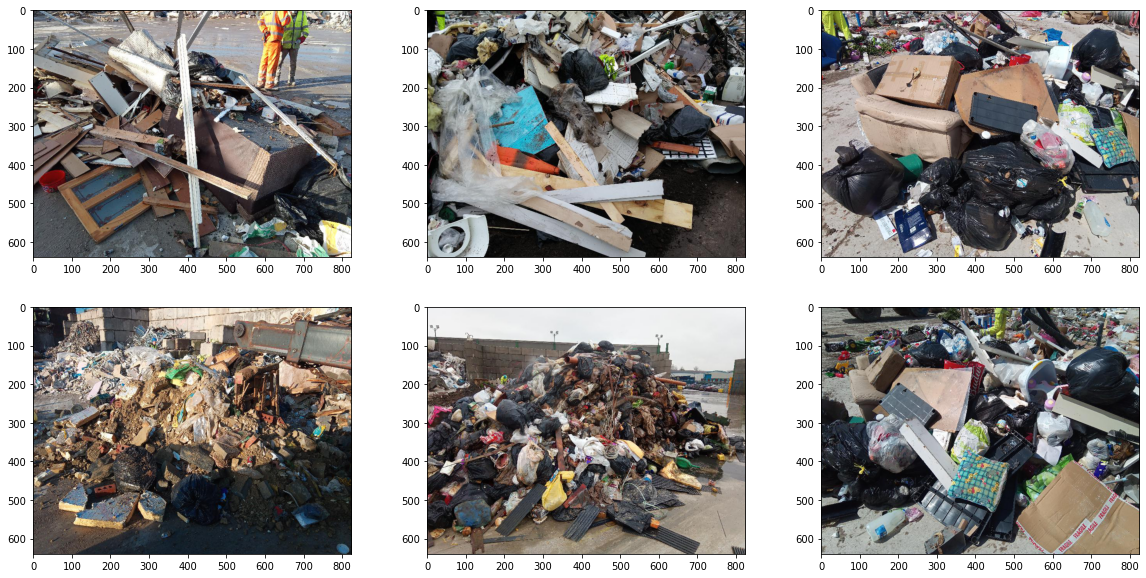

In [31]:
plt.figure(figsize=(20,10))
for i in range(6):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.show()



In [ ]:
tempdir = '/content/drive/My Drive/ML/'
!mv tempdir /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002
# !cp /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002 '/content/drive/My Drive/ML/'

mv: cannot stat '/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002': No such file or directory


# mAP

## Detection vs gt

In [27]:
idx = 0

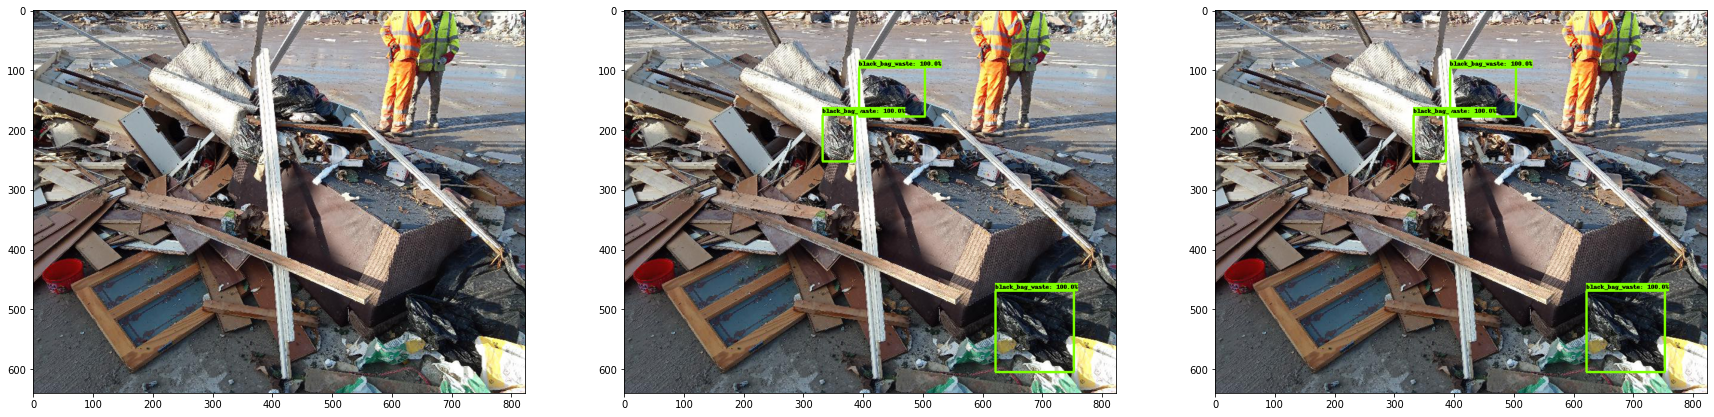

In [28]:
# idx = 3

plt.figure(figsize=(30, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 3, 1)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 3, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

plt.subplot(1, 3, 3)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes_trivial[idx],
      y_test_classes_trivial[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

idx += 1

## mAP Block

In [60]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_y1, box1_x1, box1_y2, box1_x2) = box1
    (box2_y1, box2_x1, box2_y2, box2_x2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
    xi1 = np.maximum(box1_x1, box2_x1)
    yi1 = np.maximum(box1_y1, box2_y1)
    xi2 = np.minimum(box1_x2, box2_x2)
    yi2 = np.minimum(box1_y2, box2_y2)
    inter_width = yi2 - yi1
    inter_height = xi2 - xi1
    if inter_width < 0 or inter_height < 0:
        return 0
    inter_area = inter_width * inter_height

    # Calculate the Union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    boxes: [ymin, xmin, ymax, xmax]
  '''

  ious_arr = []
  detected_which = []
  hash_table = [None] * len(gt_boxes)

  for i, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    detected_which.append(-1)
    for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[i] = j
          if not hash_table[j]:
            hash_table[j] = (max_iou, i)
          else:
            if hash_table[j][0] < max_iou:
              detected_which[hash_table[j][1]] = -1
              hash_table[j] = (max_iou, i)
              
    ious_arr.append(max_iou)

  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):

  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):
    class_eval = c + 1

    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)

    print(f'{label_names[c+1]}: {total} annotations')
    print(f'{tp} / {detection_total} correct detections \n')
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## mAP - Train

In [61]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.5)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


100%|██████████| 139/139 [00:22<00:00,  6.31it/s]


In [62]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)

print(sum(map)/num_classes)

# print('\n Trivial: ')

# p, r, map = calculate_map(detected_boxes, 
#                           detected_classes, 
#                           detected_scores, 
#                           y_train_boxes_trivial, 
#                           y_train_classes_trivial, 
#                           num_of_classes = num_classes,
#                           iou_threshold = 0.5)

# print(map)



black_bag_waste: 480 annotations
393 / 443 correct detections 

[0.6983017665662594]
0.6983017665662594


## mAP - Test

In [66]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_test_classes))):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


100%|██████████| 18/18 [00:02<00:00,  6.48it/s]


In [67]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.4)

print(map)
print(f'mAP: {sum(map)/num_classes}')

print('----------------------------------------')
print('\nExcluding difficult annotations: \n')
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes_trivial, 
                          y_test_classes_trivial, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.4)

print(map)
print(f'mAP: {sum(map)/num_classes}')

black_bag_waste: 132 annotations
73 / 109 correct detections 

[0.4318660500742411]
mAP: 0.4318660500742411
----------------------------------------

Excluding difficult annotations: 

black_bag_waste: 98 annotations
65 / 109 correct detections 

[0.5019003726100013]
mAP: 0.5019003726100013


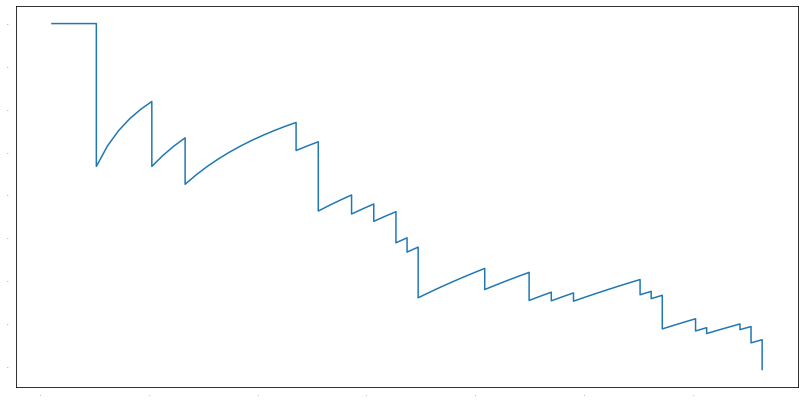

In [83]:
plt.plot(r[0], p[0])

In [84]:
print(r[0])
print(p[0])

[0.01020408 0.02040816 0.03061224 0.04081633 0.05102041 0.05102041
 0.06122449 0.07142857 0.08163265 0.09183673 0.10204082 0.10204082
 0.1122449  0.12244898 0.13265306 0.13265306 0.14285714 0.15306122
 0.16326531 0.17346939 0.18367347 0.19387755 0.20408163 0.21428571
 0.2244898  0.23469388 0.23469388 0.24489796 0.25510204 0.25510204
 0.25510204 0.25510204 0.26530612 0.2755102  0.28571429 0.28571429
 0.29591837 0.30612245 0.30612245 0.31632653 0.32653061 0.32653061
 0.32653061 0.33673469 0.33673469 0.34693878 0.34693878 0.34693878
 0.34693878 0.34693878 0.35714286 0.36734694 0.37755102 0.3877551
 0.39795918 0.40816327 0.40816327 0.40816327 0.41836735 0.42857143
 0.43877551 0.44897959 0.44897959 0.44897959 0.44897959 0.45918367
 0.46938776 0.46938776 0.47959184 0.48979592 0.48979592 0.5
 0.51020408 0.52040816 0.53061224 0.54081633 0.55102041 0.55102041
 0.55102041 0.56122449 0.56122449 0.57142857 0.57142857 0.57142857
 0.57142857 0.57142857 0.57142857 0.58163265 0.59183673 0.60204082
 0.